In [1]:
import pandas as pd
from pandas.tseries.offsets import BDay
import numpy as np
from scipy.interpolate import interp1d
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Change directory to raw data folder

In [2]:
# Get the current working directory
current_directory = os.getcwd()

# Get the parent directory by going one level up
parent_directory = os.path.dirname(current_directory)

# Get the path of raw data folder
data_raw_folder = os.path.join(parent_directory, 'data/raw')

# Change the current working directory to raw data folder
os.chdir(data_raw_folder)

# 2. Import datasets

In [3]:
# New issues data
new_issues = pd.read_csv('new_issues.csv', index_col=0)
new_issues_characteristics =  pd.read_csv('new_issues_characteristics.csv', index_col=0)
new_issues_prices_refinitive_ask =  pd.read_csv('new_issues_prices_askyield_refinitive.csv', index_col=0)
swap_rates = pd.read_csv('swap_rates.csv', index_col=0)

In [4]:
# Comparable bonds data
chunk_dfs = []
for i in range(6):
    chunk_df = pd.read_csv(f'comparable_bonds_peers_duration_iboxx_{i+1}.csv', index_col=0)
    chunk_dfs.append(chunk_df)

comparable_bonds_iboxx = pd.concat(chunk_dfs, ignore_index=True)

In [5]:
# Index data
iboxx_indices = pd.read_csv('iboxx_indices.csv', sep=';')
move_index = pd.read_csv('move_index.csv')

# 3. Modify raw datasets and create subsets

## 3.1 New issues

In [6]:
# Create new issues dataframe with selected columns
new_issues_sliced = new_issues.loc[:,['securities_isin', 'ticker', 'dealDate',
                                      'issuerType', 'paymentType', 'countryName', 'COUNTRY_ISO_CODE', 
                                      'moodys', 'sp', 'fitch', 'expectedSize', 'actualSize', 'minimumDenomination', 
                                      'securityType', 'maturityTerm', 'coupon', 'seniority_name_1', 
                                      'seniority_name_1_adj', 'esgType', 'referenceType', 'ipt_reference',
                                      'ipt_price_down', 'ipt_price_up', 'guidance_reference', 'guidance_price_down',
                                      'guidance_price_up', 'launchValue', 'reofferValue', 'yieldToMaturity', 'duration',
                                     'Industry_Group', 'Industry_Sector']]

# Change time type
new_issues_sliced['dealDate'] = pd.to_datetime(new_issues_sliced['dealDate'])
new_issues_sliced['dealDate'] = new_issues_sliced['dealDate'].dt.floor('d')

In [7]:
# Deal with duplicated isins

# Sort the DataFrame by 'dealDate' in ascending order
new_issues_sliced = new_issues_sliced.sort_values('dealDate')

# Keep the first occurrence of each ISIN
new_issues_sliced = new_issues_sliced.drop_duplicates('securities_isin', keep='first')

## 3.2 Comparable bonds

In [8]:
# Change time type
comparable_bonds_iboxx['date'] = pd.to_datetime(comparable_bonds_iboxx['date'])
comparable_bonds_iboxx['date'] = comparable_bonds_iboxx['date'].dt.floor('d')

In [9]:
# Rename column
comparable_bonds_iboxx = comparable_bonds_iboxx.rename(columns={'new_issue_isin': 'securities_isin', 'ticker': 'tickerCompBond'})

## 3.3 New issues characteristics

In [10]:
# Merge new issues with ccorresponding payment ranks
new_issues_sliced = new_issues_sliced.merge(new_issues_characteristics[['security', 'PAYMENT_RANK']], left_on = 'securities_isin', right_on = 'security', how = 'inner')
new_issues_sliced = new_issues_sliced.drop(['security'], axis=1)

## 3.4 Iboxx indices

In [11]:
# Change time type in iboxx index dataset
iboxx_indices['Download_Date'] = pd.to_datetime(iboxx_indices['Download_Date'])

In [12]:
# Create issue dataframe with selected columns
iboxx_indices_sliced = iboxx_indices.loc[:,['Download_Date', 'Name', 'Annual_Yield_to_Maturity', 'Expected_Remaining_Life']]

In [13]:
# Keep only iBoxx € Corporates Senior and iBoxx € Financials Senior
iboxx_indices_sliced = iboxx_indices_sliced[iboxx_indices_sliced['Name'].isin(['iBoxx € Corporates Senior', 'iBoxx € Financials Senior'])]

## 3.5 Swap rates

In [14]:
# Extract the column names and their corresponding years
columns = swap_rates.columns
years = []

# Determine if the column represents months or years and extract the corresponding number
for col in columns:
    match = re.search(r'(\d+)([YM])=', col)
    if match:
        num = int(match.group(1))
        unit = match.group(2)
        if unit == 'Y':
            years.append(num)
        elif unit == 'M':
            years.append(num / 12)
            
# Create a dictionary to map the old column names to the new column names
new_columns = {col: yr for col, yr in zip(columns, years)}

# Rename the columns in the DataFrame
swap_rates.rename(columns=new_columns, inplace=True)

# Sort the columns in ascending order
swap_rates = swap_rates.reindex(sorted(swap_rates.columns), axis=1)

# Change time type in refinitive prices dataset
swap_rates = swap_rates.reset_index()
swap_rates['Date'] = pd.to_datetime(swap_rates['Date'])
swap_rates['Date'] = swap_rates['Date'].dt.date
swap_rates['Date'] = swap_rates['Date'].astype('datetime64')
swap_rates['Date'] = swap_rates['Date'].dt.floor('d')
swap_rates = swap_rates.set_index('Date')

## 3.6 Create dataframe of IPT MSs of new issues

In [15]:
# MS spread from IPREO data
new_issues_ipt_ipreo = new_issues_sliced.loc[:, ['dealDate', 'securities_isin', 'maturityTerm', 'duration', 'issuerType', 'PAYMENT_RANK', 'ipt_price_down', 'ipt_price_up', 'guidance_price_down', 'guidance_price_up']]
new_issues_ipt_ipreo = new_issues_ipt_ipreo.rename(columns={'securities_isin': 'isin'})
new_issues_ipt_ipreo = new_issues_ipt_ipreo.drop_duplicates()

In [16]:
# Calculate average
new_issues_ipt_ipreo['ipt'] = (new_issues_ipt_ipreo['ipt_price_down'] + new_issues_ipt_ipreo['ipt_price_up']) / 2
new_issues_ipt_ipreo['guidance'] = (new_issues_ipt_ipreo['guidance_price_down'] + new_issues_ipt_ipreo['guidance_price_up']) / 2

In [17]:
# Initial spread is ipt, otherwise guidance
new_issues_ipt_ipreo['initialSpread'] = new_issues_ipt_ipreo['ipt'].fillna(new_issues_ipt_ipreo['guidance'])

In [18]:
# Drop unnecessary columns
new_issues_ipt_ipreo = new_issues_ipt_ipreo.drop(['ipt_price_down', 'ipt_price_up', 'guidance_price_down', 'guidance_price_up'], axis=1)

In [19]:
new_issues_ipt_ipreo = new_issues_ipt_ipreo.reset_index(drop=True)

## 3.7 Find comparable bonds at the day before issue

In [20]:
# Find previous business day
new_issues_ipt_ipreo['prevDate'] = new_issues_ipt_ipreo['dealDate'] - BDay(1)

In [21]:
# Merge comparable bonds on 'ticker' and 'prevDate' columns
new_issues_with_comp = new_issues_ipt_ipreo.merge(comparable_bonds_iboxx, left_on=['isin', 'prevDate'], right_on=['securities_isin', 'date'], how='inner')

In [22]:
# Drop unncessary columns
new_issues_with_comp = new_issues_with_comp.drop(['securities_isin'], axis=1)

In [23]:
# Keep comparable bonds with the same payment rank
new_issues_with_comp = new_issues_with_comp[new_issues_with_comp['PAYMENT_RANK']==new_issues_with_comp['Payment_Rank']]

In [27]:
# Calculate the maturity difference
new_issues_with_comp['maturity_diff_abs'] = abs(new_issues_with_comp['maturityTerm'] - new_issues_with_comp['Time_To_Maturity'])

In [28]:
# Keep bonds with close maturities (difference < 0.5 year)
new_issues_with_comp_filtered = new_issues_with_comp.loc[new_issues_with_comp['maturity_diff_abs'] <= 0.5]
new_issues_with_comp_filtered = new_issues_with_comp_filtered.reset_index(drop=True)

## 3.7 Calculate swap rate and spread for comparable bonds

In [30]:
# Extract the maturities from column names
maturities = [col for col in swap_rates.columns]

# Interpolate the swap rate curve for each timestamp
interpolated_swap_rates = {}
for timestamp, row in swap_rates.iterrows():
    swap_rate_interpolator = interp1d(maturities, row, kind='cubic')
    interpolated_swap_rates[timestamp] = swap_rate_interpolator

In [31]:
# Rename column
new_issues_with_comp_filtered = new_issues_with_comp_filtered.rename(columns={'securities_isin': 'isin'})

In [32]:
# Calculate the corresponding swap rates for comparable bonds
def calculate_swap_rate_bond(row):
    try:
        return interpolated_swap_rates[row['prevDate']](row['Time_To_Maturity'])
    except (KeyError, ValueError):
        return None

new_issues_with_comp_filtered['Swap Rate Comp Bond'] = new_issues_with_comp_filtered.apply(calculate_swap_rate_bond, axis=1)

In [33]:
new_issues_with_comp_filtered = new_issues_with_comp_filtered[~new_issues_with_comp_filtered['Swap Rate Comp Bond'].isnull()]

In [34]:
# Calculate MS for comparable bonds
new_issues_with_comp_filtered['compBondMS'] = new_issues_with_comp_filtered['Annual_Yield_to_Maturity'] - new_issues_with_comp_filtered['Swap Rate Comp Bond']
new_issues_with_comp_filtered['compBondMS'] = new_issues_with_comp_filtered['compBondMS'] * 100

# 4. Spread to Peers Analysis

In [35]:
# Calculate NIP
new_issues_with_comp_filtered['spreadToPeers'] = new_issues_with_comp_filtered['initialSpread'] - new_issues_with_comp_filtered['compBondMS']

In [36]:
# Groupe the dataframe by 'isin' and 'dealDate' and calculate the average of 'NIP'
issues_spread_peers = new_issues_with_comp_filtered.groupby(['isin', 'dealDate']).agg({'spreadToPeers': 'mean'}).reset_index()
issues_spread_peers = issues_spread_peers.drop(['dealDate'], axis=1)
issues_spread_peers['spreadToPeers'] = issues_spread_peers['spreadToPeers'].astype(float)

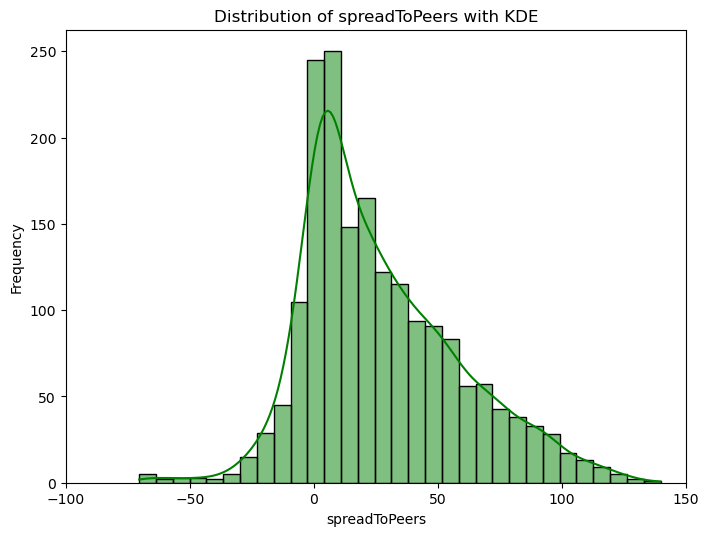

In [37]:
# Plot the distribution of 'NIP'
# Set the style
# sns.set_style("darkgrid")

plt.figure(figsize=(8, 6), dpi=100)

#ax = sns.histplot(data=issues_nip_average, x="NIP", kde=False, stat='density', bins=100)
#sns.kdeplot(data=issues_nip_average, x="NIP", color='crimson', ax=ax)
sns.histplot(data=issues_spread_peers, x="spreadToPeers", kde=True, color='green', alpha=0.5)

plt.xlabel('spreadToPeers', fontdict={'fontsize': 10})
plt.ylabel('Frequency', fontdict={'fontsize': 10})
plt.title('Distribution of spreadToPeers with KDE', fontdict={'fontsize': 12})

plt.xlim(-100, 150)

plt.show()

In [38]:
# issues_spread_peers.to_csv('spread_to_peers.csv')